# Assignment 3 - Task 1

Group: David, Chrisitan

Goal: Measure impact of distribution shifts in the `Worker.profession` input feature.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import json

import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

2025-02-09 14:56:21.812343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 14:56:24.117857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739109385.064640     921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739109385.348340     921 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 14:56:28.004707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Dataset preparation

In preparation we split the dataset into "Students" (i.e. "Graduates" and "Undergraduates") and "Non-Students".

We split the "Students" dataset into a training and holdout set by a factor of `0.2`.
To ensure an even distribution of `GroundTruth` values across both sets, we split the "Students" dataset by `GroundTruth` value, and randomly select 20% of each for the holdout set.

In [13]:
df = pd.read_csv('answerList_data.csv')

# Split dataset into students and non-students
def split_dataset(df):
    students = ['Undergraduate_Student', 'Graduate_Student']
    students_df = df[df['Worker.profession'].isin(students)]
    non_students_df = df[~df['Worker.profession'].isin(students)]
    return students_df, non_students_df

students_df, non_students_df = split_dataset(df)

# Split dataframe into train and test set
def split_train_test(df, factor=0.2):
    df_gt = df[df['GroundTruth'] == 1]
    df_ngt = df[df['GroundTruth'] == 0]
    df_gt_train, df_gt_test = sklearn.model_selection.train_test_split(df_gt, test_size=factor)
    df_ngt_train, df_ngt_test = sklearn.model_selection.train_test_split(df_ngt, test_size=factor)
    df_train = pd.concat([df_gt_train, df_ngt_train], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])
    df_test = pd.concat([df_gt_test, df_ngt_test], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])
    return df_train, df_test

students_train_df, students_test_df = split_train_test(students_df)

In [14]:
# Convert dataframes to datasets
label = "GroundTruth"

students_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_train_df, label=label)
students_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_test_df, label=label)

## Classifier training

We use the `tfdf` module and train the student classifier using a random forest model with a tuner.

In [15]:
# Train classifier
#
# Skip if previously trained model and train/test split has been saved

tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)
students_classifier = tfdf.keras.RandomForestModel(tuner=tuner)

students_classifier.fit(students_train_ds, verbose=2)

Use /tmp/tmpcodpymw1 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

In [18]:
# Optionally save trained classifier model and train/test split used

path = "models/students_classifier"
overwrite = True
if (not os.path.isdir(path)) or overwrite:
    students_classifier.save(path, overwrite=overwrite)

    students_train_id = students_train_df['Answer.ID'].to_list()
    students_test_id = students_test_df['Answer.ID'].to_list()
    with open(path + '_split.txt', 'w', encoding='utf-8') as f:
        json.dump({'train_id': students_train_id, 'test_id': students_test_id}, f)

INFO:tensorflow:Assets written to: models/students_classifier/assets


INFO:tensorflow:Assets written to: models/students_classifier/assets


In [19]:
# Optionally load a previously saved model and train/test split used
import tensorflow as tf

def load_model(path):
    classifier = tf.keras.models.load_model(path)
    with open(path + '_split.txt', 'r') as f:
        split = json.load(f)
    train_id = split['train_id']
    test_id = split['test_id']
    train_df = df[df['Answer.ID'].isin(train_id)].drop(columns=['TN', 'FN', 'TP', 'FP'])
    test_df = df[df['Answer.ID'].isin(test_id)].drop(columns=['TN', 'FN', 'TP', 'FP'])
    return classifier, train_df, test_df

path = "models/students_classifier"
students_classifier, students_train_df, students_test_df = load_model(path)

label = "GroundTruth"
students_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_train_df, label=label)
students_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_test_df, label=label)

2025-02-09 15:23:16.877566: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path models/students_classifier/assets/ with prefix 89ee8a69c34f409e
I0000 00:00:1739110999.791129    2397 decision_forest.cc:761] Model loaded with 300 root(s), 20866 node(s), and 19 input feature(s).
I0000 00:00:1739110999.791171    2397 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2025-02-09 15:23:19.791186: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


## Classifier evaluation

To evaluate the performance of the student classifier we compile loss, precision, and recall on the holdout (i.e. test) set.

In [20]:
students_classifier.compile(metrics=['Precision', 'Recall'])
students_classifier_evaluation = students_classifier.evaluate(students_test_ds, return_dict=True)

for metric, value in students_classifier_evaluation.items():
    print(f"{metric}: {value:.4f}")

1/1 [==============================] - 0s 166ms/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 0.6129
loss: 0.0000
precision: 1.0000
recall: 0.6129


In this instance, the random forest classifier with a tuner running 100 trials, the loss is at `0.0000`, precision is at `1.0000`, and recall is at `0.6129`.

### Predictions

Additionally, we generate a plot to visualize how often the classifier predicted true/false.

In [21]:
students_classifier_predictions = students_classifier.predict(students_test_ds, verbose=2)

1/1 - 0s - 52ms/epoch - 52ms/step


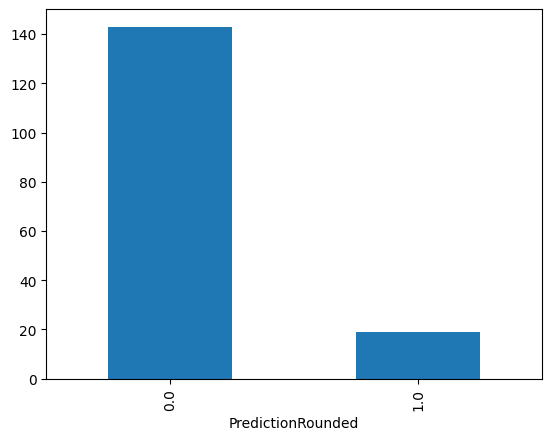

In [22]:
def get_test_eval(dataframe):
    test_eval = dataframe.copy()
    test_eval['Prediction'] = students_classifier_predictions
    test_eval['PredictionRounded'] = students_classifier_predictions
    test_eval.PredictionRounded = test_eval.PredictionRounded.round()
    test_eval['RightPrediction'] = np.where(test_eval['PredictionRounded'] == test_eval['GroundTruth'], True, False)
    test_eval['ExplanationLength'] = test_eval['Answer.explanation'].str.len()
    return test_eval

students_test_eval_df = get_test_eval(students_test_df)
students_test_eval_plot = students_test_eval_df['PredictionRounded'].value_counts().plot(kind='bar')

## Distribution shifts in holdout set

To explore distribution shifts based on the `Worker.profession` input feature, we gradually add explanations from non-students, split off earlier.

We decided on adding entries in small batches of 10 over a comparatively large number of rounds, 150 in total, while evaluating the changes in loss, precision, and recall after each round.

In [33]:
students_classifier.compile(metrics=['Precision', 'Recall'])

def generate_shift_evaluations(classifier, students_test_df, non_students_df, batch_size, rounds):
    non_students_shuffled_df = sklearn.utils.shuffle(non_students_df).drop(columns=['TP', 'TN', 'FP', 'FN'])
    label = "GroundTruth"
    evaluations = []

    for i in range(1, rounds):
        test_df = students_test_df.copy()
        test_df = pd.concat([test_df, non_students_shuffled_df.iloc[0:i*batch_size]])
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label)
        evaluations.append(classifier.evaluate(test_ds, return_dict=True))
    return df.from_records(evaluations)

shift_evaluations_df = generate_shift_evaluations(students_classifier, students_test_df, non_students_df, batch_size=10, rounds=150)

2/2 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - precision: 0.9957 - recall: 0.7287


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

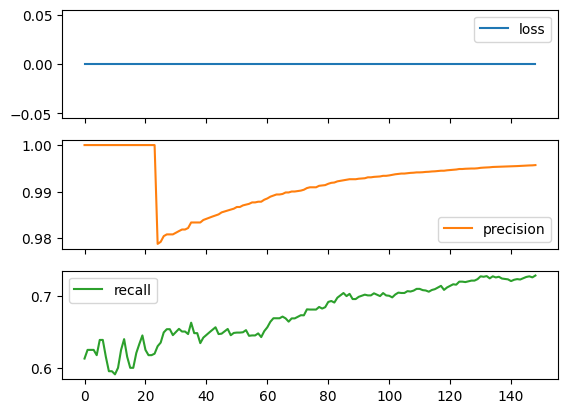

In [34]:
shift_evaluations_df.plot(subplots=True)

As is visible on the plots loss remains unchanged across the rounds. This behaviour was consistent across multiple runs of the above randomization. Precision stayed stable at `1.0` for most runs, for a  small number of rounds the precision dropped abruptly, then steadily climbed back up, however the value only ever dropped by at most about `0.02`.

The recall, in contrast, fluctuates a bit more during the first about 25 rounds. In the majority of randomized runs the recall rises steeply or fluctuates around the original value, but never drops far below it. As the rounds go on the value climbs to about, or just above, `0.7` and remains relatively stable towards the end.

## Classifier training while adding non-students

We gradually add non-student entries to the students dataset, and repeatedly train new classifiers on the combined set, in order to determine the impact the non-students have on the classifier performance.

We add non-students entries in batches of 100 over a total of 16 rounds.

Due to the number of rounds we use a tuner with less trials for classifier training. During each round the existing train/test split is kept the same, to which the new entries are being added.

In [ ]:
import sklearn.model_selection
import tqdm

def batch_train_eval_classifiers(students_df, non_students_df, batch_size, rounds, tuner_trials):
    non_students_shuffled_df = sklearn.utils.shuffle(non_students_df).drop(columns=['TP', 'TN', 'FP', 'FN'])
    label = "GroundTruth"

    students_gt_df = students_df[students_df['GroundTruth'] == 1].drop(columns=['TP', 'TN', 'FP', 'FN'])
    students_ngt_df = students_df[students_df['GroundTruth'] == 0].drop(columns=['TP', 'TN', 'FP', 'FN'])
    students_gt_train_df, students_gt_test_df = sklearn.model_selection.train_test_split(students_gt_df, test_size=0.2)
    students_ngt_train_df, students_ngt_test_df = sklearn.model_selection.train_test_split(students_ngt_df, test_size=0.2)

    combined_train_df = pd.concat([students_gt_train_df, students_ngt_train_df], ignore_index=True)
    combined_test_df = pd.concat([students_gt_test_df, students_ngt_test_df], ignore_index=True)

    classifiers = []

    for i in tqdm.tqdm(range(0, rounds)):
        start = i * batch_size
        end = start + batch_size

        new_df = non_students_shuffled_df.iloc[start:end]
        new_gt_df = new_df[new_df['GroundTruth'] == 1]
        new_ngt_df = new_df[new_df['GroundTruth'] == 0]

        new_gt_train_df, new_gt_test_df = sklearn.model_selection.train_test_split(new_gt_df, test_size=0.2)
        new_ngt_train_df, new_ngt_test_df = sklearn.model_selection.train_test_split(new_ngt_df, test_size=0.2)

        combined_train_df = pd.concat([combined_train_df, new_gt_train_df, new_ngt_train_df])
        combined_test_df = pd.concat([combined_test_df, new_gt_test_df, new_ngt_test_df])

        try:
            assert pd.Series(combined_train_df['Answer.ID']).is_unique and pd.Series(combined_test_df['Answer.ID']).is_unique
        except Exception as e:
            print(e)

        combined_train_id = combined_train_df['Answer.ID'].to_list()
        combined_test_id = combined_test_df['Answer.ID'].to_list()
        combined_split = {'train_id': combined_train_id, 'test_id': combined_test_id}

        combined_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combined_train_df, label=label)
        combined_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combined_test_df, label=label)

        combined_tuner = tfdf.tuner.RandomSearch(num_trials=tuner_trials, use_predefined_hps=True)
        combined_classifier = tfdf.keras.RandomForestModel(tuner=combined_tuner)
        combined_classifier.fit(combined_train_ds, verbose=2)

        combined_classifier.compile(['Precision', 'Recall'])
        classifiers.append({'classifier': combined_classifier, 'split': combined_split, 'evaluation': combined_classifier.evaluate(combined_test_ds, return_dict=True)})

    return classifiers

batch_size = 100
rounds = 16
tuner_trials = 10
combined_classifiers = batch_train_eval_classifiers(students_df, non_students_df, batch_size=batch_size, rounds=rounds, tuner_trials=tuner_trials)

  0%|          | 0/16 [00:00<?, ?it/s]

Use /tmp/tmp9omj27as as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

  6%|▋         | 1/16 [01:15<18:53, 75.57s/it]

Use /tmp/tmpmmnd2j1u as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 12%|█▎        | 2/16 [02:39<18:43, 80.22s/it]

Use /tmp/tmpby1gzzz0 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 19%|█▉        | 3/16 [04:12<18:43, 86.42s/it]

Use /tmp/tmpzkgafg0w as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 25%|██▌       | 4/16 [05:56<18:36, 93.04s/it]

Use /tmp/tmpj5l9ld30 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 31%|███▏      | 5/16 [07:49<18:26, 100.56s/it]

Use /tmp/tmp47trzl9q as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 38%|███▊      | 6/16 [09:56<18:12, 109.30s/it]

Use /tmp/tmpnzh_17z6 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 44%|████▍     | 7/16 [12:14<17:48, 118.67s/it]

Use /tmp/tmpmet6el64 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 50%|█████     | 8/16 [14:44<17:09, 128.72s/it]

Use /tmp/tmppl75ibdw as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 56%|█████▋    | 9/16 [17:27<16:16, 139.52s/it]

Use /tmp/tmpfinyqmtg as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 62%|██████▎   | 10/16 [20:24<15:05, 150.90s/it]

Use /tmp/tmpd7nf_4db as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 69%|██████▉   | 11/16 [23:31<13:30, 162.15s/it]

Use /tmp/tmpri18gp65 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 75%|███████▌  | 12/16 [26:50<11:33, 173.37s/it]

Use /tmp/tmpilxic5v8 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 81%|████████▏ | 13/16 [30:48<09:38, 192.75s/it]

Use /tmp/tmplekkka_n as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 88%|████████▊ | 14/16 [35:22<07:14, 217.45s/it]

Use /tmp/tmpzclv0kgc as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

 94%|█████████▍| 15/16 [39:53<03:53, 233.41s/it]

Use /tmp/tmp6_e9v82r as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, 'Wor

100%|██████████| 16/16 [44:51<00:00, 168.21s/it]


In [ ]:
# Optionally save trained classifier model and train/test split used
#
# note: method to load saved combined classifiers not implemented atm

def save_classifier(classifier, split, path, overwrite):
    classifier.save(path, overwrite=overwrite)
    with open(path + '_split.txt', 'w', encoding='utf-8') as f:
        json.dump(split, f)

overwrite = True
for index, item in enumerate(combined_classifiers):
    path = f"models/combined_classifier_{index:02d}"
    save_classifier(item['classifier'], item['split'], path, overwrite)

INFO:tensorflow:Assets written to: models/combined_classifier_00/assets


INFO:tensorflow:Assets written to: models/combined_classifier_00/assets


INFO:tensorflow:Assets written to: models/combined_classifier_01/assets


INFO:tensorflow:Assets written to: models/combined_classifier_01/assets


INFO:tensorflow:Assets written to: models/combined_classifier_02/assets


INFO:tensorflow:Assets written to: models/combined_classifier_02/assets


INFO:tensorflow:Assets written to: models/combined_classifier_03/assets


INFO:tensorflow:Assets written to: models/combined_classifier_03/assets


INFO:tensorflow:Assets written to: models/combined_classifier_04/assets


INFO:tensorflow:Assets written to: models/combined_classifier_04/assets


INFO:tensorflow:Assets written to: models/combined_classifier_05/assets


INFO:tensorflow:Assets written to: models/combined_classifier_05/assets


INFO:tensorflow:Assets written to: models/combined_classifier_06/assets


INFO:tensorflow:Assets written to: models/combined_classifier_06/assets


INFO:tensorflow:Assets written to: models/combined_classifier_07/assets


INFO:tensorflow:Assets written to: models/combined_classifier_07/assets


INFO:tensorflow:Assets written to: models/combined_classifier_08/assets


INFO:tensorflow:Assets written to: models/combined_classifier_08/assets


INFO:tensorflow:Assets written to: models/combined_classifier_09/assets


INFO:tensorflow:Assets written to: models/combined_classifier_09/assets


INFO:tensorflow:Assets written to: models/combined_classifier_10/assets


INFO:tensorflow:Assets written to: models/combined_classifier_10/assets


INFO:tensorflow:Assets written to: models/combined_classifier_11/assets


INFO:tensorflow:Assets written to: models/combined_classifier_11/assets


INFO:tensorflow:Assets written to: models/combined_classifier_12/assets


INFO:tensorflow:Assets written to: models/combined_classifier_12/assets


INFO:tensorflow:Assets written to: models/combined_classifier_13/assets


INFO:tensorflow:Assets written to: models/combined_classifier_13/assets


INFO:tensorflow:Assets written to: models/combined_classifier_14/assets


INFO:tensorflow:Assets written to: models/combined_classifier_14/assets


INFO:tensorflow:Assets written to: models/combined_classifier_15/assets


INFO:tensorflow:Assets written to: models/combined_classifier_15/assets


In [57]:
combined_classifiers_eval = [cl['evaluation'] for cl in combined_classifiers]
for eval in combined_classifiers_eval:
    print(eval)

{'loss': 0.0, 'precision': 1.0, 'recall': 0.4000000059604645}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.5249999761581421}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.7045454382896423}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.5833333134651184}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.7307692170143127}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.7857142686843872}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.7966101765632629}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.8571428656578064}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9130434989929199}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9041095972061157}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9615384340286255}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9756097793579102}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9772727489471436}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9780219793319702}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9789473414421082}
{'loss': 0.0, 'precision': 1.0, 'recall': 0.9797979593276978}


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

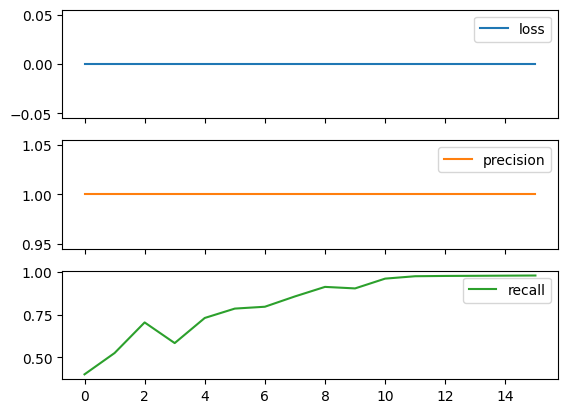

In [58]:
combined_classifiers_eval_df = pd.DataFrame(combined_classifiers_eval)
combined_classifiers_eval_df.plot(subplots=True)

As the above plot shows, the trained classifier steadily increases in accuracy as more non-student entries are added to the dataset. The initial recall is below that of the classifier trained only on student entries above. This discrepancy could be explained by the reduced number of trials used for the tuner during the repeated training of combined classifiers, a number that has been reduced in order to finish the runs in a more permissible timeframe.

Still, even with the comparatively low starting value, the classifiers outperform the classification accuracy we achieved during our previous project. Since we did not split the dataset by method this time, we suspect that the more even split into train/test sets might have a positive impact on the resulting trained classifier.